In [98]:
!nvidia-smi

Mon Apr 19 22:11:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.67       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 2060    Off  | 00000000:01:00.0  On |                  N/A |
| N/A   55C    P8     8W /  N/A |   1785MiB /  5934MiB |     13%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [99]:
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler

In [100]:
import pickle # 
from os import path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [101]:
data = pd.read_csv('data/UNSW_NB15_training-set.csv')
data.head()

,id,dur,xProt,xServ,xState,spkts,dpkts,sbytes,dbytes,rate,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,1,0.121478,4,999,2,6,4,258,172,74.087490,...,1,1,1,0,0,0,1,1,0,0
1,2,0.649902,4,999,2,14,38,734,42014,78.473372,...,1,1,2,0,0,0,1,6,0,0
2,3,1.623129,4,999,2,8,16,364,13186,14.170161,...,1,1,3,0,0,0,2,6,0,0
3,4,1.681642,4,3,2,12,12,628,770,13.677108,...,1,1,3,1,1,0,2,1,0,0
4,5,0.449454,4,999,2,10,6,534,268,33.373826,...,2,1,40,0,0,0,2,39,0,0


In [102]:
X = data.iloc[: , :-1].values
X.shape

(175341, 43)

In [103]:
attacks = list(pd.unique(data["label"]))
attacks

[0, 1]

In [104]:
y = np.array(list(map((lambda x: attacks.index(x)), data.iloc[: , -1].values)))
y.shape

(175341,)

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape, y_train.shape, y_test.shape

((140272, 43), (140272,), (140272,), (35069,))

In [106]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

------------------------------------------------------------------------------------------------------------------

In [107]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [108]:
class NSL_KDD(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [109]:
train_data = NSL_KDD(torch.Tensor(X_train), torch.Tensor(y_train))
test_data = NSL_KDD(torch.Tensor(X_test), torch.Tensor(y_test))

In [110]:
bs = 256

train_loader = DataLoader(dataset=train_data, batch_size=bs, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=bs)

In [111]:
len(train_loader.dataset)//bs + 1, len(test_loader.dataset)//bs + 1

(548, 137)

In [112]:
class Teacher(nn.Module):

    def __init__(self, n_features, n_classes):
        super(Teacher, self).__init__()

        self.mlp = nn.Sequential(*[
            nn.Linear(n_features, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, n_classes)
        ])

    def forward(self, x):
        return self.mlp(x)

In [113]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [114]:
teacher = Teacher(X_train.shape[1], len(attacks)).to(device)
teacher

Teacher(
  (mlp): Sequential(
    (0): Linear(in_features=43, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=2, bias=True)
  )
)

In [115]:
sum(p.numel() for p in teacher.parameters())

2090

In [116]:
loss_fn = nn.CrossEntropyLoss()
teacher_optimizer = optim.SGD(teacher.parameters(), lr=0.01, momentum=0.9)

In [117]:
def accuracy(preds, labels):
        
    preds = F.softmax(preds, dim=1).argmax(dim=1)
    n_correct = (preds==labels).sum().float()
    
    return (n_correct/len(labels)).item()
    

In [118]:
n_epochs = 50

Epoch 1: Loss = 158.23888170719147, Average epoch accuracy = 0.8658331433569428
Epoch 6: Loss = 59.14612138643861, Average epoch accuracy = 0.9527434041030216
Epoch 11: Loss = 50.730321768671274, Average epoch accuracy = 0.9623312994728993
Epoch 16: Loss = 42.57793686538935, Average epoch accuracy = 0.9680761481723646
Epoch 21: Loss = 38.47857201099396, Average epoch accuracy = 0.9707344891163554
Epoch 26: Loss = 34.43950115330517, Average epoch accuracy = 0.9735216127477423
Epoch 31: Loss = 32.0851029464975, Average epoch accuracy = 0.9753621122697844
Epoch 36: Loss = 30.708490900695324, Average epoch accuracy = 0.9765320865124681
Epoch 41: Loss = 29.585794706828892, Average epoch accuracy = 0.9770234566535393
Epoch 46: Loss = 28.544629780575633, Average epoch accuracy = 0.9777015854407402


Text(0, 0.5, 'Loss')

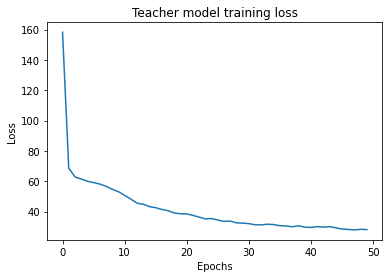

In [119]:
epoch_losses = []
epoch_accuracies = []

for e in range(n_epochs):
    running_loss = 0
    batch_accuracies = []
    
    for i, (data, labels) in enumerate(train_loader):
        
        teacher_optimizer.zero_grad()
        
        data, labels = data.to(device), labels.to(device).long()
        preds = teacher(data)
        loss = loss_fn(preds, labels)
        
        loss.backward()
        teacher_optimizer.step()
        
        running_loss += loss.item()
        batch_accuracies.append(accuracy(preds, labels))
        
#         if i%50==0:
#             print(f"Average accuracy = {sum(batch_accuracies)/len(batch_accuracies)}")
    
    epoch_losses.append(running_loss)
    epoch_accuracies.append(sum(batch_accuracies)/len(batch_accuracies))
    
    if (e%5 == 0):
        print(f"Epoch {e+1}: Loss = {epoch_losses[e]}, Average epoch accuracy = {epoch_accuracies[e]}")

plt.plot(epoch_losses)
plt.title("Teacher model training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [120]:
accuracies = []
for data, labels in test_loader:
    
    data, labels = data.to(device), labels.to(device)
    preds = teacher(data)
    accuracies.append(accuracy(preds, labels))
print(f"Average accuracy = {sum(accuracies)/len(accuracies)}")

Average accuracy = 0.9777305095735258


In [121]:
class Student(nn.Module):

    def __init__(self, n_features, n_classes):
        super(Student, self).__init__()

        self.mlp = nn.Sequential(*[
            nn.Linear(n_features, 8),
            nn.ReLU(),
            nn.Linear(8, n_classes)
        ])

    def forward(self, x):
        return self.mlp(x)

In [122]:
student = Student(X_train.shape[1], len(attacks)).to(device)
student

Student(
  (mlp): Sequential(
    (0): Linear(in_features=43, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=2, bias=True)
  )
)

In [123]:
sum(p.numel() for p in student.parameters())

370

In [124]:
student_optimizer = optim.SGD(student.parameters(), lr=0.01, momentum=0.9)

Epoch 1: Loss = 127.13001264631748, Average epoch accuracy = 0.9025699514759719
Epoch 6: Loss = 67.47551638633013, Average epoch accuracy = 0.9481642526866746
Epoch 11: Loss = 64.1680811829865, Average epoch accuracy = 0.9506610212099813
Epoch 16: Loss = 63.122423745691776, Average epoch accuracy = 0.9514294404835597
Epoch 21: Loss = 62.41486815363169, Average epoch accuracy = 0.9518077099410287
Epoch 26: Loss = 61.450386226177216, Average epoch accuracy = 0.9526706965517824
Epoch 31: Loss = 60.982770547270775, Average epoch accuracy = 0.9526179479639025
Epoch 36: Loss = 60.55586414039135, Average epoch accuracy = 0.9520700274810304
Epoch 41: Loss = 60.199975069612265, Average epoch accuracy = 0.952223996393872
Epoch 46: Loss = 59.85674108937383, Average epoch accuracy = 0.95220261181358


Text(0, 0.5, 'Loss')

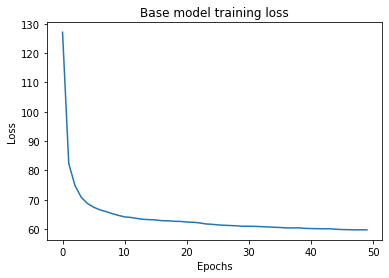

In [125]:
epoch_losses = []
epoch_accuracies = []

for e in range(n_epochs):
    running_loss = 0
    batch_accuracies = []
    
    for i, (data, labels) in enumerate(train_loader):
        
        student_optimizer.zero_grad()
        
        data, labels = data.to(device), labels.to(device).long()
        preds = student(data)
        loss = loss_fn(preds, labels)
        
        loss.backward()
        student_optimizer.step()
        
        running_loss += loss.item()
        batch_accuracies.append(accuracy(preds, labels))
        
#         if i%50==0:
#             print(f"Average accuracy = {sum(batch_accuracies)/len(batch_accuracies)}")
    
    epoch_losses.append(running_loss)
    epoch_accuracies.append(sum(batch_accuracies)/len(batch_accuracies))
    
    if (e%5 == 0):
        print(f"Epoch {e+1}: Loss = {epoch_losses[e]}, Average epoch accuracy = {epoch_accuracies[e]}")

plt.plot(epoch_losses)
plt.title("Base model training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [126]:
accuracies = []
for data, labels in test_loader:
    
    data, labels = data.to(device), labels.to(device)
    preds = student(data)
    accuracies.append(accuracy(preds, labels))
    
print(f"Average accuracy = {sum(accuracies)/len(accuracies)}")

Average accuracy = 0.9516966569162634


In [127]:
student = Student(X_train.shape[1], len(attacks)).to(device)
student

Student(
  (mlp): Sequential(
    (0): Linear(in_features=43, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=2, bias=True)
  )
)

In [128]:
student_optimizer = optim.SGD(student.parameters(), lr=0.1, momentum=0.9)

Epoch 1: Loss = 55.21856279298663, Average epoch accuracy = 0.9218388839359701
Epoch 6: Loss = 34.55339614674449, Average epoch accuracy = 0.9483082421722203
Epoch 11: Loss = 32.40151357278228, Average epoch accuracy = 0.9527619374494483
Epoch 16: Loss = 28.37672029621899, Average epoch accuracy = 0.9619159634313444
Epoch 21: Loss = 27.43432273901999, Average epoch accuracy = 0.9633587098469699
Epoch 26: Loss = 26.522734459489584, Average epoch accuracy = 0.9648679859229248
Epoch 31: Loss = 26.413170341402292, Average epoch accuracy = 0.9647952783716857
Epoch 36: Loss = 26.557523312047124, Average epoch accuracy = 0.9650414387022492
Epoch 41: Loss = 25.992405470460653, Average epoch accuracy = 0.9656159710274995
Epoch 46: Loss = 25.376288494095206, Average epoch accuracy = 0.9663093066128501


Text(0, 0.5, 'Loss')

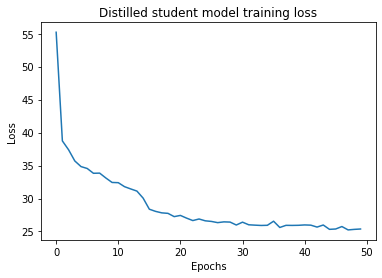

In [129]:
distil_weight = 0.5

epoch_losses = []
epoch_accuracies = []

for e in range(n_epochs):
    running_loss = 0
    batch_accuracies = []
    
    for i, (data, labels) in enumerate(train_loader):
        
        student_optimizer.zero_grad()
        
        data, labels = data.to(device), labels.to(device).long()
        student_preds = student(data)
        loss = (1-distil_weight) * loss_fn(student_preds, labels)
        
        teacher_preds = teacher(data)
        soft_student_probs = F.log_softmax(student_preds/10, dim=1)
        soft_teacher_probs = F.softmax(teacher_preds/10, dim=1)
        loss += distil_weight * F.kl_div(soft_student_probs, soft_teacher_probs.detach(), reduction='batchmean')
        
        loss.backward()
        student_optimizer.step()
        
        running_loss += loss.item()
        batch_accuracies.append(accuracy(student_preds, labels))
        
#         if i%50==0:
#             print(f"Average accuracy = {sum(batch_accuracies)/len(batch_accuracies)}")
    
    epoch_losses.append(running_loss)
    epoch_accuracies.append(sum(batch_accuracies)/len(batch_accuracies))
    
    if (e%5 == 0):
        print(f"Epoch {e+1}: Loss = {epoch_losses[e]}, Average epoch accuracy = {epoch_accuracies[e]}")

plt.plot(epoch_losses)
plt.title("Distilled student model training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [130]:
accuracies = []
for data, labels in test_loader:
    
    data, labels = data.to(device), labels.to(device)
    preds = student(data)
    accuracies.append(accuracy(preds, labels))
    
print(f"Average accuracy = {sum(accuracies)/len(accuracies)}")

Average accuracy = 0.965126173339621


In [131]:
sum(p.numel() for p in student.parameters())

370